### Importações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from imshow3d import imshow3d

### Estruturas de dados

A classe `AutomatoCelular`, gera as estruturas principais do autômato celular contador de distâncias.

Para cada célula existe uma tupla com quatro valores (id_material, dx, dy, dz), mas nesse exeplo
o material vai ser constante. E em vez de usar valores de tuplas para cada celula de matriz, iremos criar três matrizes distintas com os valores para cada indice da tupla do modelo de Colombo.

A matriz de ativação (ativado) define o estado de propagação, verdadeiro para quando a célula já realizou o seu devido trabalho.

In [2]:
class AutomatoCelular:
    def __init__(self, tamanho_malha):
        self.tamanho_malha = tamanho_malha
        self.dx = np.full((tamanho_malha, tamanho_malha, tamanho_malha), np.inf)
        self.dy = np.full((tamanho_malha, tamanho_malha, tamanho_malha), np.inf)
        self.dz = np.full((tamanho_malha, tamanho_malha, tamanho_malha), np.inf)
        self.ativado = np.zeros((tamanho_malha, tamanho_malha, tamanho_malha), dtype=bool)

    def set(self, i, j, k, valor=(0,0,0)):
        self.dx[i,j,k], self.dy[i,j,k], self.dz[i,j,k] = valor

    def get(self, i, j, k):
        return self.dx[i,j,k], self.dy[i,j,k], self.dz[i,j,k]

    def ativar(self, i, j, k):
        self.ativado[i,j,k] = True

### Funções especiais

- Função de processamento, no processo de autômatos o valor da célula é definida dependendo de seu estado e dos seus vizinhos, mas para questão de otimização do modelo de Colombo, em vez de ter uma segunda matriz de dados, o autor propós usar a célula atual para propagar sua informação entre seus vizinhos, caso ela for a melhor escolha.
- Em seu método de otimização, foi proposto usar uma lista para armazenar as células que representam a frente de onda, assim é possível mapear toda a matriz e ao mesmo tempo processar a propagação da informação das frentes de ondas.

In [3]:
def processar(ac, pontos_emissao):

    # Fila de processamento da propagação da frente de onda
    frente_onda = deque()

    # Inicializando os pontos de emissão
    for i, j, k in pontos_emissao:
        ac.set(i,j,k)
        ac.ativar(i,j,k)
        frente_onda.append((i, j, k))

    # Enquanto tiver frentes de onda para propagar
    while frente_onda:

        # Removendo a primeira célula da frente de onda
        i, j, k = frente_onda.popleft()

        # Distância pertecente a célula atual
        distancia_atual = ac.get(i,j,k)
        
        # Vetores unitários dos vizinhos da célula
        vetores = [
            ( 1,  0,  0), # Direita
            (-1,  0,  0), # Esquerda
            ( 0,  1,  0), # Cima
            ( 0, -1,  0), # baixo
            ( 0,  0,  1), # frente
            ( 0,  0, -1)  # atrás
        ]

        # Percorrendo os vizinhos
        for vi, vj, vk in vetores:
            # Posição do vizinho
            pos_i, pos_j, pos_k = i+vi, j+vj, k+vk
            
            # Verifica a célula pertence a malha
            namalha = lambda v_: 0 <= v_ < ac.tamanho_malha
            if namalha(pos_i) and namalha(pos_j) and namalha(pos_k):
                
                # Calcula as novas distâncias do vizinho
                novo_dx = distancia_atual[0] + abs(vi)
                novo_dy = distancia_atual[1] + abs(vj)
                novo_dz = distancia_atual[2] + abs(vk)
                nova_distancia = novo_dx**2 + novo_dy**2 + novo_dz**2
                
                # Distância atual do vizinho
                vdx, vdy, vdz = ac.get(pos_i, pos_j, pos_k)
                distancia_vizinho = vdx**2 + vdy**2 + vdz**2

                # Define para o vizinho a melhor distância
                if nova_distancia < distancia_vizinho:
                    # Atualiza com a melhor distância
                    ac.set(pos_i, pos_j, pos_k, valor=(novo_dx, novo_dy, novo_dz))

                    # Adiciona o vizinho para ser uma nova frente de onda
                    ac.ativar(pos_i, pos_j, pos_k)
                    frente_onda.append((pos_i, pos_j, pos_k))


- Função de visualização, ela realiza o calculo de magnitude das distâncias do modelo, e plota por padrão as cores ao decorrer do tempo ou
  o padrão de ondas quando o parâmetro **seno** é verdadeiro.

In [4]:
def visualizacao(ac, pos_faces=(0,0,0), seno=False):
    p_yz, p_xz, p_xy = pos_faces
    
    mapa = np.sqrt(ac.dx**2 + ac.dy**2 + ac.dz**2)
    mapa = np.sin(mapa) if seno else mapa

    tam = ac.tamanho_malha
    meio = tam // 2
    mg_xy = mapa[:tam, :tam, p_xy]
    mg_xz = mapa[:tam, p_xz, :tam]
    mg_yz = mapa[p_yz, :tam, :tam]
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=30, azim=45)
    
    imshow3d(ax, mg_yz, value_direction='z', cmap='inferno')
    imshow3d(ax, mg_xz, value_direction='x', cmap='inferno')
    imshow3d(ax, mg_yz, value_direction='y', cmap='inferno')
    
    plt.show()

# Simulações


### Simulação de pontos de emissão de ondas

Único ponto no eixo zero

In [5]:
ac1 = AutomatoCelular(50)
pontos_emissao = [(0,0,0)]
processar(ac1, pontos_emissao)

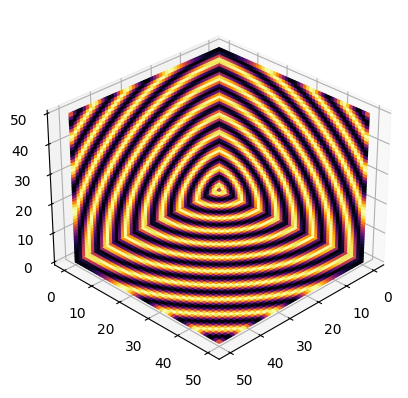

In [6]:
visualizacao(ac1, seno=True)

Único ponto no centro

In [7]:
ac2 = AutomatoCelular(50)
pontos_emissao = [(25,25,25)]
processar(ac2, pontos_emissao)

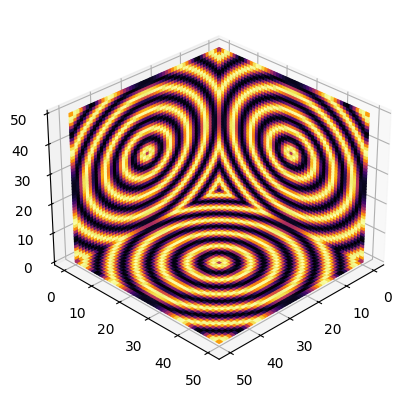

In [9]:
# Representação das faces retiradas do corte central para os três eixos
visualizacao(ac2, pos_faces=(25,25,25), seno=True)